*Model saved at epoch 1*
Epoch 1/100: Train Loss: 0.7745 (E: 0.6444, C: 0.1833, S: 0.1774), Val Loss: 21.7611 (E: 41.5440, C: 0.6594, S: 0.0000), LR: 0.001000
*Model saved at epoch 2*
Epoch 2/100: Train Loss: 0.5636 (E: 0.5219, C: 0.1030, S: 0.1482), Val Loss: 4.7232 (E: 7.1429, C: 0.2784, S: 0.7343), LR: 0.000976
*Model saved at epoch 3*
Epoch 3/100: Train Loss: 0.3875 (E: 0.3602, C: 0.0595, S: 0.1181), Val Loss: 4.2468 (E: 7.1429, C: 0.2772, S: 0.2596), LR: 0.000905
*Model saved at epoch 4*
Epoch 4/100: Train Loss: 0.3170 (E: 0.3087, C: 0.0690, S: 0.0592), Val Loss: 3.9868 (E: 7.1429, C: 0.2769, S: 0.0000), LR: 0.000794
*Model saved at epoch 5*
Epoch 5/100: Train Loss: 0.2989 (E: 0.2815, C: 0.0797, S: 0.0386), Val Loss: 3.6004 (E: 6.3701, C: 0.2769, S: 0.0000), LR: 0.000655
Epoch 6/100: Train Loss: 0.2715 (E: 0.2379, C: 0.0831, S: 0.0280), Val Loss: 3.7857 (E: 6.7406, C: 0.2769, S: 0.0000), LR: 0.000501
*Model saved at epoch 7*
Epoch 7/100: Train Loss: 0.2905 (E: 0.2994, C: 0.0796, S

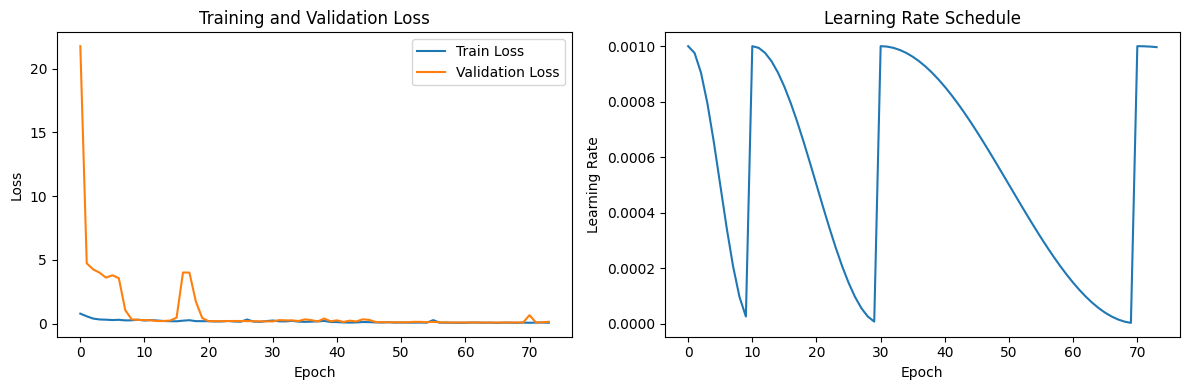

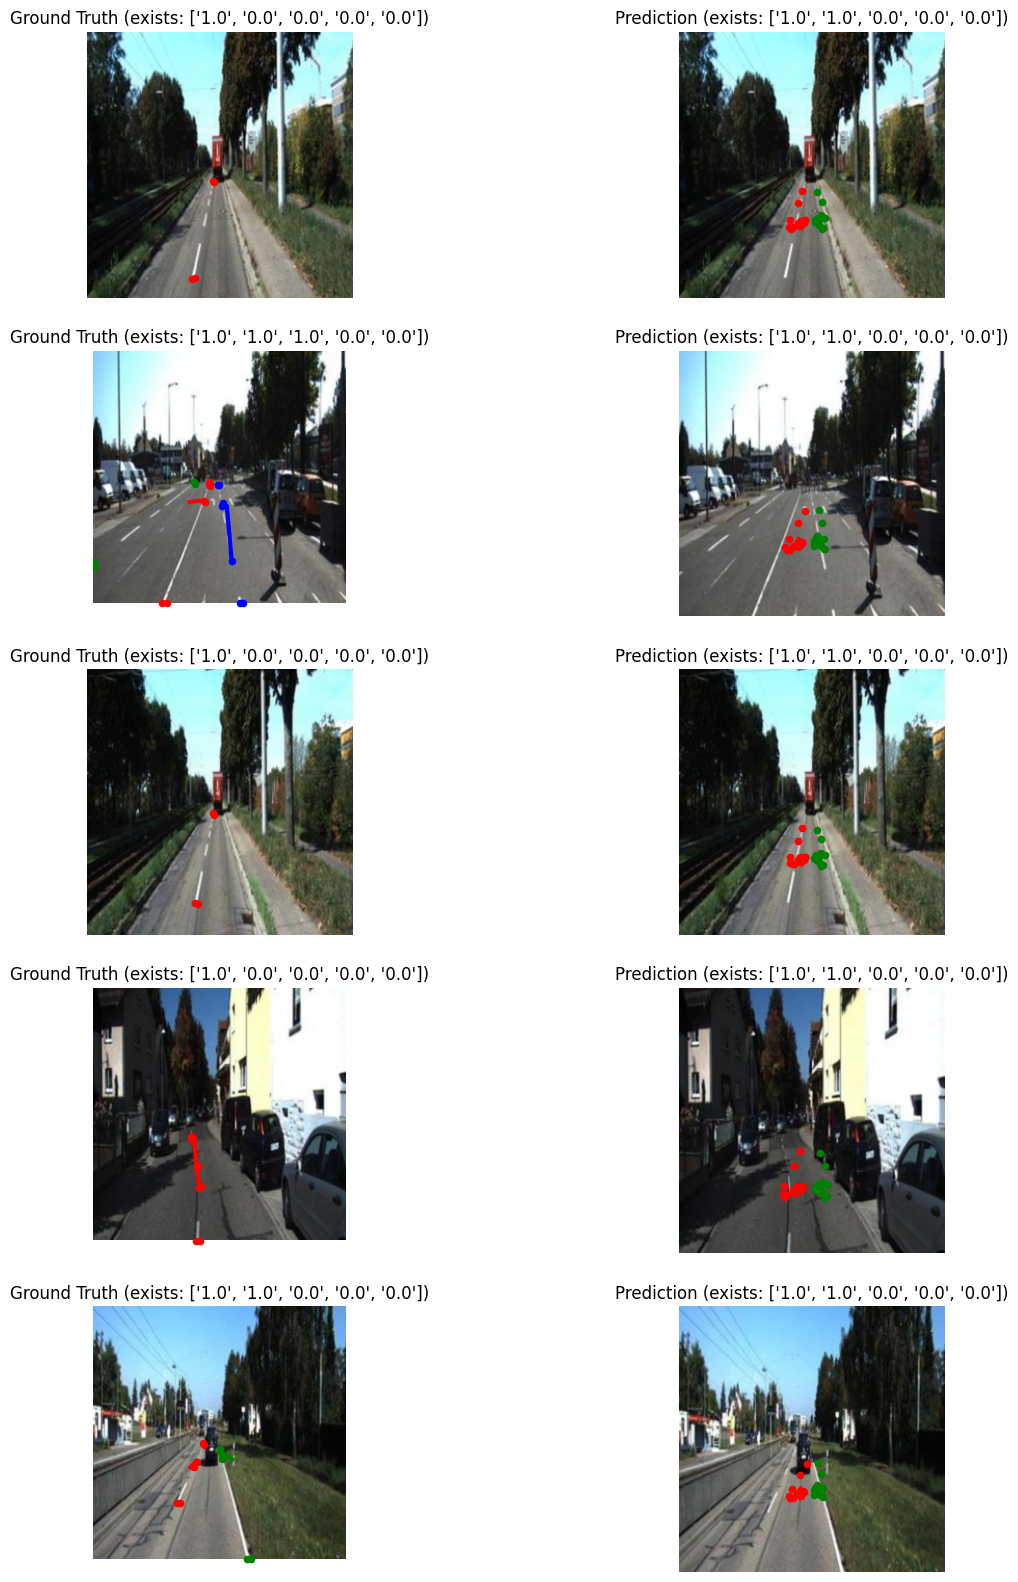

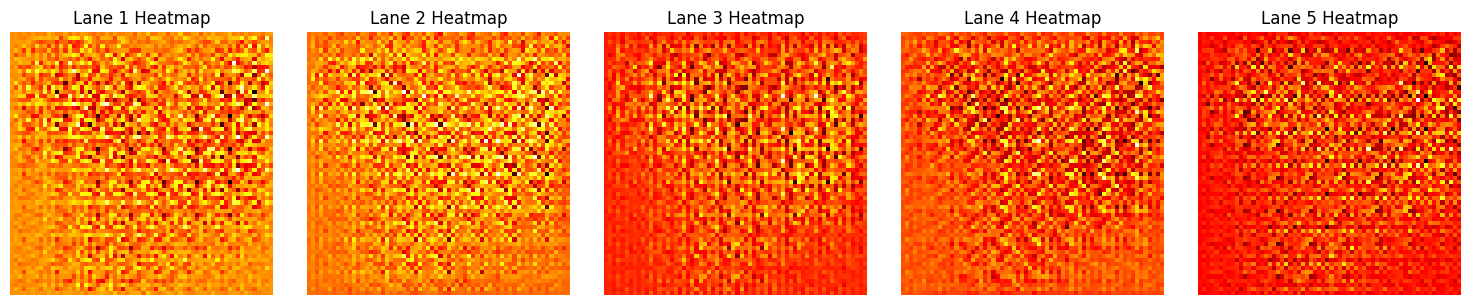

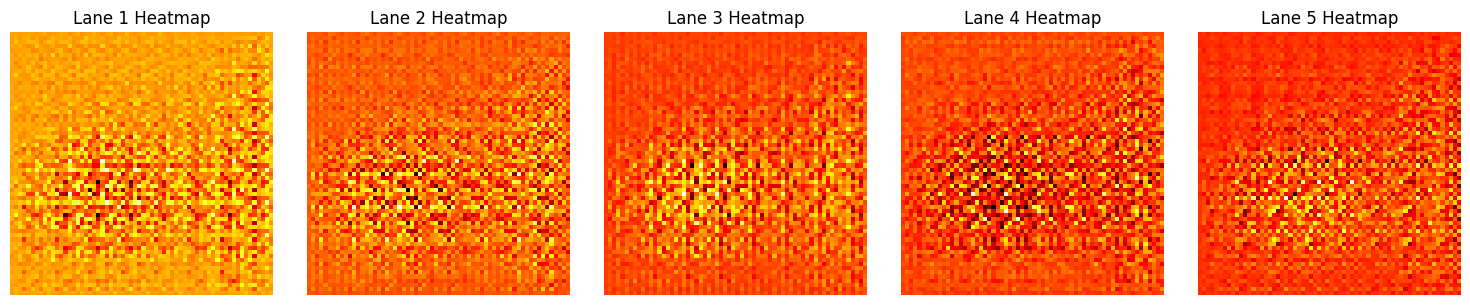

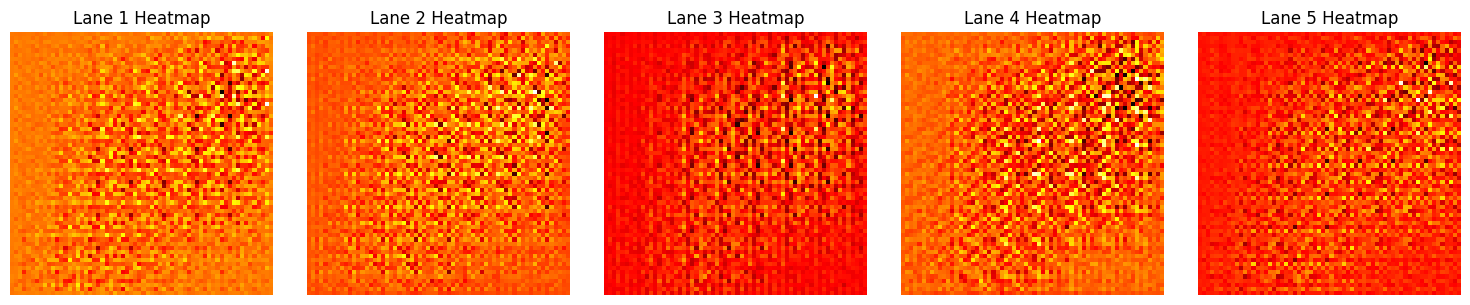

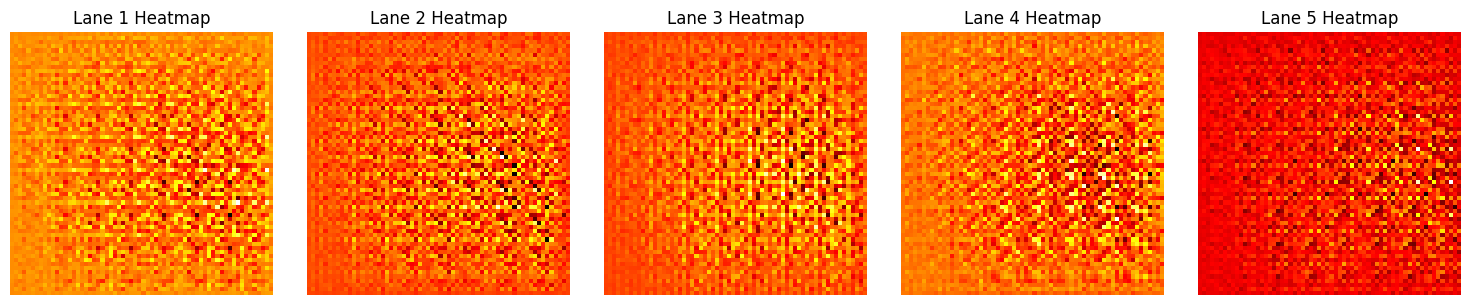

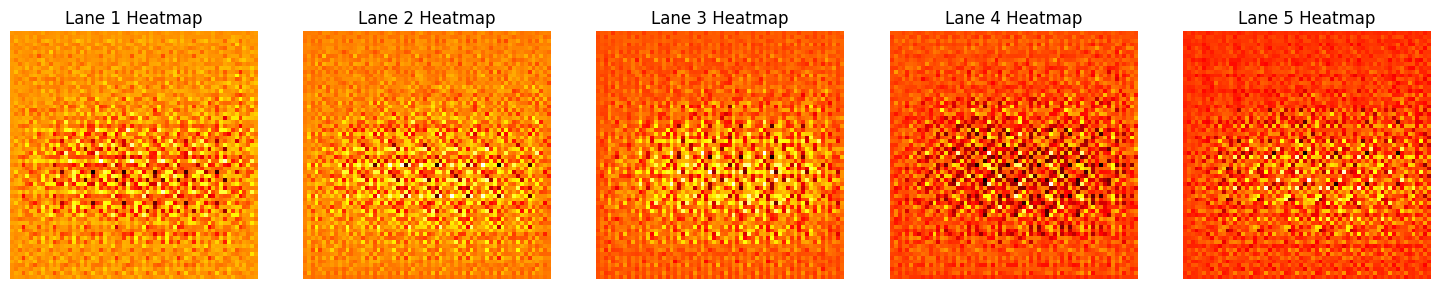

In [7]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

class LaneLineDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, img_size=(256, 256)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_size = img_size
        
        # Get list of image files
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))])
        self.label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])
        
        # Ensure matching files
        img_basenames = [os.path.splitext(f)[0] for f in self.image_files]
        lbl_basenames = [os.path.splitext(f)[0] for f in self.label_files]
        
        common_basenames = list(set(img_basenames) & set(lbl_basenames))
        
        # Filter to include only files with both image and label
        self.image_files = [f for f in self.image_files if os.path.splitext(f)[0] in common_basenames]
        self.label_files = [os.path.splitext(f)[0] + '.txt' for f in self.image_files]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])

        # Load and transform image
        image = Image.open(img_path).convert("RGB")
        orig_width, orig_height = image.size
        
        if self.transform:
            image = self.transform(image)
        
        # Load label (YOLO format)
        lane_lines = []
        with open(label_path, "r") as f:
            for line in f:
                values = list(map(float, line.strip().split()))
                if not values:
                    continue
                    
                class_id = int(values[0])  # First value is the class
                # Rest are polygon coordinates in normalized form [x1, y1, x2, y2, ...]
                polygon = torch.tensor(values[1:])
                
                # Ensure even number of coordinates
                if len(polygon) % 2 != 0:
                    polygon = polygon[:-1]  # Remove last element if odd
                
                # Reshape to pairs of coordinates
                points = polygon.view(-1, 2)
                
                # Remove duplicate points (first = last in closed polygons)
                if points.size(0) > 1 and torch.all(points[0] == points[-1]):
                    points = points[:-1]
                    
                # Sort by y-coordinate (top to bottom)
                if points.size(0) > 1:  # Only sort if more than one point
                    indices = torch.argsort(points[:, 1])
                    points = points[indices]
                
                # Flatten back to 1D and store
                lane_lines.append(points.reshape(-1))
        
        # Create lane existence indicator
        max_lanes = 5
        lane_exists = torch.zeros(max_lanes)
        for i in range(min(len(lane_lines), max_lanes)):
            lane_exists[i] = 1.0
        
        # Convert list of polygons to padded tensor
        points_per_lane = 30  # Should be even (pairs of x,y)
        
        # Create tensor filled with padding value (-1)
        lanes_tensor = torch.ones((max_lanes, points_per_lane)) * -1
        
        # Fill in the actual lane data
        for i, lane in enumerate(lane_lines):
            if i >= max_lanes:
                break  # Skip if more than max_lanes
            
            # Ensure we don't exceed points_per_lane
            points_to_copy = min(lane.shape[0], points_per_lane)
            lanes_tensor[i, :points_to_copy] = lane[:points_to_copy]
        
        return image, lanes_tensor, lane_exists

# Using ResNet-like blocks for better feature extraction
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class EnhancedLaneNet(nn.Module):
    def __init__(self, max_lanes=5, points_per_lane=30):
        super(EnhancedLaneNet, self).__init__()
        
        self.max_lanes = max_lanes
        self.points_per_lane = points_per_lane

        # Initial convolution layers with increased channel depth
        self.initial = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # Encoder with deeper residual blocks
        self.layer1 = self._make_layer(64, 128, 3)
        self.layer2 = self._make_layer(128, 256, 4, stride=2)
        self.layer3 = self._make_layer(256, 512, 6, stride=2)
        self.layer4 = self._make_layer(512, 512, 3, stride=2)
        
        # Global context module (attention)
        self.context = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Lane existence prediction with dropout
        self.exists_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, max_lanes),
            nn.Sigmoid()
        )
        
        # Improved decoder for better spatial resolution
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        # Lane instance segmentation head
        self.seg_head = nn.Conv2d(64, max_lanes, kernel_size=1)
        
        # Improved coordinate regression head with regularization
        self.coord_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, max_lanes * points_per_lane)
        )

    def _make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Feature extraction
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        features = self.layer4(x)
        
        # Apply global context attention
        context = self.context(features)
        features = features * context
        
        # Lane existence prediction
        existence = self.exists_head(features)
        
        # Decode features to spatial heatmaps
        decoded = self.decoder(features)
        lane_heatmaps = self.seg_head(decoded)
        
        # Lane coordinate prediction
        coords = self.coord_head(features)
        coords = coords.view(-1, self.max_lanes, self.points_per_lane)
        
        # Apply sigmoid to ensure coordinates are in [0,1] range
        coords = torch.sigmoid(coords)
        
        # Apply existence masking to coordinates (zero out non-existent lanes)
        existence_mask = existence.unsqueeze(2).repeat(1, 1, self.points_per_lane)
        coords = coords * existence_mask
        
        return coords, existence, lane_heatmaps

# Enhanced loss function with stronger smoothness constraint at bottom of lanes
class ImprovedLaneLoss(nn.Module):
    def __init__(self, existence_weight=0.5, coordinate_weight=1.0, smoothness_weight=1.0, 
                 heatmap_weight=0.5, y_weight_factor=2.0):
        super(ImprovedLaneLoss, self).__init__()
        self.existence_weight = existence_weight
        self.coordinate_weight = coordinate_weight
        self.smoothness_weight = smoothness_weight
        self.heatmap_weight = heatmap_weight
        self.y_weight_factor = y_weight_factor  # Weight factor for bottom of lanes
        self.bce = nn.BCELoss()
        self.mse = nn.MSELoss(reduction='none')
        self.bce_with_logits = nn.BCEWithLogitsLoss()
    
    def forward(self, pred_coords, pred_exists, lane_heatmaps, target_coords, target_exists):
        # Lane existence loss
        existence_loss = self.bce(pred_exists, target_exists)
        
        # Coordinate loss with masking
        lane_mask = target_exists.unsqueeze(-1).expand_as(target_coords)
        point_mask = (target_coords != -1).float()
        mask = lane_mask * point_mask
        
        # Apply MSE loss only on valid points of valid lanes
        coord_loss = self.mse(pred_coords, target_coords)
        
        # Weight y-coordinates more (especially bottom points)
        batch_size = pred_coords.shape[0]
        max_lanes = pred_coords.shape[1]
        points_per_pair = pred_coords.shape[2] // 2
        
        # Create weights that increase for lower points in the image (larger y values)
        y_weights = torch.ones_like(coord_loss)
        
        # Reshape to separate x and y coordinates
        coord_loss_reshaped = coord_loss.view(batch_size, max_lanes, -1, 2)
        mask_reshaped = mask.view(batch_size, max_lanes, -1, 2)
        
        # Get sorted indices of y-coordinates (from top to bottom)
        reshaped_target = target_coords.view(batch_size, max_lanes, -1, 2)
        valid_mask = (reshaped_target[:, :, :, 1] != -1)
        
        # Apply increasing weights to y-coordinate errors
        for b in range(batch_size):
            for l in range(max_lanes):
                if target_exists[b, l] > 0.5:
                    valid_indices = valid_mask[b, l].nonzero(as_tuple=True)[0]
                    if len(valid_indices) > 0:
                        # Create weight vector that increases from top to bottom
                        num_valid = len(valid_indices)
                        weights = torch.linspace(1.0, self.y_weight_factor, num_valid, device=pred_coords.device)
                        
                        # Apply weights to y-coordinate errors
                        for i, idx in enumerate(valid_indices):
                            coord_loss_reshaped[b, l, idx, 1] *= weights[i]
        
        # Reshape back
        coord_loss = coord_loss_reshaped.view(batch_size, max_lanes, -1)
        
        # Apply mask and average
        masked_loss = coord_loss * mask
        valid_points = mask.sum()
        if valid_points > 0:
            coordinate_loss = masked_loss.sum() / valid_points
        else:
            coordinate_loss = torch.tensor(0.0, device=pred_coords.device)
            
        # Enhanced smoothness loss - penalize non-smooth curves more at bottom
        smoothness_loss = torch.tensor(0.0, device=pred_coords.device)
        
        if valid_points > 0:
            # Reshape to get x,y pairs
            pred_reshaped = pred_coords.view(batch_size, max_lanes, -1, 2)
            
            # Compute differences between consecutive points (first derivatives)
            point_diffs = pred_reshaped[:, :, 1:] - pred_reshaped[:, :, :-1]
            
            # Compute second derivatives (change in slopes)
            if point_diffs.shape[2] > 1:
                second_derivatives = point_diffs[:, :, 1:] - point_diffs[:, :, :-1]
                
                # Create a mask for valid second derivatives
                valid_lanes_mask = target_exists.view(batch_size, max_lanes, 1, 1)
                sd_mask = valid_lanes_mask.expand(-1, -1, second_derivatives.shape[2], 2)
                
                # Create weights that increase from top to bottom
                if second_derivatives.shape[2] > 0:
                    weight_factors = torch.linspace(1.0, self.y_weight_factor, 
                                                   second_derivatives.shape[2], 
                                                   device=pred_coords.device)
                    weight_factors = weight_factors.view(1, 1, -1, 1).expand_as(second_derivatives)
                    
                    # Apply weighted penalty (higher weight for bottom points)
                    if sd_mask.sum() > 0:
                        smoothness_loss = (torch.sum(torch.sum(second_derivatives**2 * weight_factors, dim=3) * 
                                          sd_mask[:, :, :, 0]) / sd_mask[:, :, :, 0].sum())
                    
        # Heatmap loss - using binary cross entropy with logits
        heatmap_loss = torch.tensor(0.0, device=pred_coords.device)
                    
        # Combined loss
        total_loss = (self.existence_weight * existence_loss + 
                      self.coordinate_weight * coordinate_loss +
                      self.smoothness_weight * smoothness_loss +
                      self.heatmap_weight * heatmap_loss)
        
        return total_loss, existence_loss, coordinate_loss, smoothness_loss

# Custom collate function
def custom_collate_fn(batch):
    images = []
    lanes = []
    lane_exists = []
    
    for image, lane, exists in batch:
        images.append(image)
        lanes.append(lane)
        lane_exists.append(exists)
    
    images = torch.stack(images)
    lanes = torch.stack(lanes)
    lane_exists = torch.stack(lane_exists)
    
    return images, lanes, lane_exists

# Improved training function with better learning rate scheduling and early stopping
def train_model(model, train_loader, val_loader, num_epochs=100, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Loss and optimizer
    criterion = ImprovedLaneLoss(
        existence_weight=0.5, 
        coordinate_weight=1.5, 
        smoothness_weight=1.0, 
        heatmap_weight=0.5,
        y_weight_factor=3.0  # Higher penalty for bottom points
    )
    
    # Using AdamW optimizer for better regularization
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=0.001, 
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )
    
    # Cosine annealing learning rate scheduler with warm restarts
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=10,  # Initial restart interval
        T_mult=2,  # Multiplier for restart interval
        eta_min=1e-6  # Minimum learning rate
    )
    
    best_val_loss = float('inf')
    best_epoch = 0
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    
    for epoch in range(num_epochs):
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        
        # Train phase
        model.train()
        train_loss = 0.0
        train_coord_loss = 0.0
        train_exist_loss = 0.0
        train_smooth_loss = 0.0
        
        for images, lane_coords, lane_exists in train_loader:
            images = images.to(device)
            lane_coords = lane_coords.to(device)
            lane_exists = lane_exists.to(device)
            
            # Forward pass
            pred_coords, pred_exists, lane_heatmaps = model(images)
            loss, exist_loss, coord_loss, smooth_loss = criterion(
                pred_coords, pred_exists, lane_heatmaps, lane_coords, lane_exists
            )
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_exist_loss += exist_loss.item()
            train_coord_loss += coord_loss.item()
            train_smooth_loss += smooth_loss.item()
        
        # Step the learning rate scheduler after each epoch
        scheduler.step()
        
        train_loss /= len(train_loader)
        train_exist_loss /= len(train_loader)
        train_coord_loss /= len(train_loader)
        train_smooth_loss /= len(train_loader)
        
        history['train_loss'].append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_coord_loss = 0.0
        val_exist_loss = 0.0
        val_smooth_loss = 0.0
        
        with torch.no_grad():
            for images, lane_coords, lane_exists in val_loader:
                images = images.to(device)
                lane_coords = lane_coords.to(device)
                lane_exists = lane_exists.to(device)
                
                pred_coords, pred_exists, lane_heatmaps = model(images)
                loss, exist_loss, coord_loss, smooth_loss = criterion(
                    pred_coords, pred_exists, lane_heatmaps, lane_coords, lane_exists
                )
                
                val_loss += loss.item()
                val_exist_loss += exist_loss.item()
                val_coord_loss += coord_loss.item()
                val_smooth_loss += smooth_loss.item()
        
        val_loss /= len(val_loader)
        val_exist_loss /= len(val_loader)
        val_coord_loss /= len(val_loader)
        val_smooth_loss /= len(val_loader)
        
        history['val_loss'].append(val_loss)
        
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            epochs_no_improve = 0
            
            # Save best model
            torch.save(model.state_dict(), 'best_lane_model.pth')
            print(f"*Model saved at epoch {epoch+1}*")
        else:
            epochs_no_improve += 1
        
        print(f'Epoch {epoch+1}/{num_epochs}: ' 
              f'Train Loss: {train_loss:.4f} (E: {train_exist_loss:.4f}, C: {train_coord_loss:.4f}, S: {train_smooth_loss:.4f}), '
              f'Val Loss: {val_loss:.4f} (E: {val_exist_loss:.4f}, C: {val_coord_loss:.4f}, S: {val_smooth_loss:.4f}), '
              f'LR: {current_lr:.6f}')
        
        # Early stopping
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}. Best model was at epoch {best_epoch+1}.')
            break
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['lr'], label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.tight_layout()
    plt.savefig('training_history.png')
    
    return history, best_epoch

# Visualization functions
def visualize_lane_predictions(model, dataloader, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Get samples for visualization
    samples = []
    with torch.no_grad():
        for images, lane_coords, lane_exists in dataloader:
            batch_size = images.shape[0]
            for i in range(min(batch_size, num_samples - len(samples))):
                samples.append((
                    images[i].clone(),
                    lane_coords[i].clone(),
                    lane_exists[i].clone()
                ))
            if len(samples) >= num_samples:
                break
    
    # Create figure for visualization
    fig, axes = plt.subplots(num_samples, 2, figsize=(14, 4 * num_samples))
    
    with torch.no_grad():
        for i, (image, ground_truth, gt_exists) in enumerate(samples):
            # Get prediction
            image_tensor = image.unsqueeze(0).to(device)
            pred_coords, pred_exists, lane_heatmaps = model(image_tensor)
            pred_coords = pred_coords[0].cpu()
            pred_exists = pred_exists[0].cpu()
            
            # Convert to numpy for visualization
            img_np = image.permute(1, 2, 0).numpy()
            
            # Denormalize image for better visualization
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_np = img_np * std + mean
            img_np = np.clip(img_np, 0, 1)
            
            # Ground truth image
            axes[i, 0].imshow(img_np)
            axes[i, 0].set_title(f"Ground Truth (exists: {[f'{x:.1f}' for x in gt_exists.tolist()]})")
            plot_lanes(axes[i, 0], ground_truth, gt_exists, img_np.shape[1], img_np.shape[0])
            axes[i, 0].axis('off')
            
            # Prediction image
            axes[i, 1].imshow(img_np)
            axes[i, 1].set_title(f"Prediction (exists: {[f'{x:.1f}' for x in pred_exists.tolist()]})")
            plot_lanes(axes[i, 1], pred_coords, pred_exists, img_np.shape[1], img_np.shape[0])
            axes[i, 1].axis('off')
            
            # Visualize heatmaps for each sample
            heatmaps = lane_heatmaps[0].cpu()
            fig_heat, axes_heat = plt.subplots(1, heatmaps.shape[0], figsize=(15, 3))
            for j, heatmap in enumerate(heatmaps):
                if heatmaps.shape[0] == 1:
                    ax = axes_heat
                else:
                    ax = axes_heat[j]
                ax.imshow(heatmap.numpy(), cmap='hot')
                ax.set_title(f"Lane {j+1} Heatmap")
                ax.axis('off')
            plt.tight_layout()
            plt.savefig(f'heatmaps_sample_{i}.png')
    
    plt.tight_layout()
    plt.savefig('lane_predictions.png')
    plt.show()

def plot_lanes(ax, lane_data, lane_exists, img_width, img_height):
    colors = ['r', 'g', 'b', 'c', 'm']
    
    # Lower threshold for lane existence
    lane_threshold = 0.3
    
    # Reshape lane data to get x,y pairs
    lane_data_reshaped = lane_data.reshape(lane_data.shape[0], -1, 2)
    
    for lane_idx, lane in enumerate(lane_data_reshaped):
        # Skip invalid lanes
        if lane_idx >= len(lane_exists) or lane_exists[lane_idx] < lane_threshold:
            continue
        
        # Filter out invalid points (marked with -1)
        valid_points = []
        for point in lane:
            if point[0] != -1 and point[1] != -1:
                # Unnormalize coordinates if needed
                x = point[0] * img_width
                y = point[1] * img_height
                valid_points.append((x, y))
        
        # Sort points by y-coordinate to ensure correct lane drawing
        valid_points.sort(key=lambda p: p[1])
        
        if valid_points:
            # Extract x and y coordinates
            points_x, points_y = zip(*valid_points)
            
            # Use spline smoothing for visualization
            if len(points_x) > 2:
                # Simple smoothing by taking running average
                smooth_x = np.array(points_x)
                window_size = min(5, len(smooth_x))
                if window_size > 2:
                    weights = np.ones(window_size) / window_size
                    smooth_x = np.convolve(smooth_x, weights, mode='valid')
                    smooth_y = points_y[(window_size-1)//2:-(window_size-1)//2]
                    ax.plot(smooth_x, smooth_y, color=colors[lane_idx % len(colors)], linewidth=3)
                else:
                    ax.plot(points_x, points_y, color=colors[lane_idx % len(colors)], linewidth=3)
            else:
                # Plot the lane with appropriate color
                ax.plot(points_x, points_y, color=colors[lane_idx % len(colors)], linewidth=3)
            
            # Mark individual points
            ax.scatter(points_x, points_y, color=colors[lane_idx % len(colors)], s=20)

def main():
    # Define transforms with enhanced data augmentation
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
        transforms.RandomHorizontalFlip(p=0.5),  # Only if your dataset supports flipping
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = LaneLineDataset(
        image_dir="../ComputerVisionGroup/train/images",
        label_dir="../ComputerVisionGroup/train/labels",
        transform=train_transform
    )
    
    # Split into train and validation with stratification if possible
    val_size = int(0.15 * len(train_dataset))  # Increased validation set size
    train_size = len(train_dataset) - val_size
    
    # Simple random split
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    # Apply test transform to validation dataset
    val_dataset.dataset.transform = test_transform
    
    test_dataset = LaneLineDataset(
        image_dir="../Maanasa/train/images",
        label_dir="../Maanasa/train/labels",
        transform=test_transform
    )
    
    # Create dataloaders WITH NUM_WORKERS=0 TO FIX THE ERROR
    batch_size = 16
    train_dataloader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=custom_collate_fn,
        num_workers=0  # Changed from 2 to 0 to fix multiprocessing issue
    )
    
    val_dataloader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=custom_collate_fn,
        num_workers=0  # Changed from 2 to 0
    )
    
    test_dataloader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=custom_collate_fn,
        num_workers=0  # Changed from 2 to 0
    )
    
    # Visualization dataloader with smaller batch size
    test_dataloader_viz = DataLoader(
        test_dataset, 
        batch_size=1, 
        shuffle=True, 
        collate_fn=custom_collate_fn,
        num_workers=0  # Changed from 2 to 0
    )
    
    # Initialize model
    model = EnhancedLaneNet(max_lanes=5, points_per_lane=30)
    
    # Train the model
    history = train_model(
        model, 
        train_dataloader, 
        val_dataloader, 
        num_epochs=100
    )
    
    # Load best model for visualization
    model.load_state_dict(torch.load('best_lane_model.pth'))
    
    # Visualize predictions
    visualize_lane_predictions(model, test_dataloader_viz, num_samples=5)

if __name__ == "__main__":
    main()